In [ ]:
!pip install import-ipynb

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
import import_ipynb
from dataLoader import *

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(123)

# Define the MobileNet-based encoder-decoder model
def create_depth_estimation_model(input_shape=(256, 256, 3)):
    # Encoder: Pretrained MobileNet
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the encoder during initial training

    # Extract intermediate layers for skip connections
    skip_connections = [
        base_model.get_layer("conv_pw_1_relu").output,  # 112x112x64
        base_model.get_layer("conv_pw_3_relu").output,  # 56x56x128
        base_model.get_layer("conv_pw_5_relu").output,  # 28x28x256
        base_model.get_layer("conv_pw_11_relu").output, # 14x14x512
    ]
    encoder_output = base_model.output  # Final encoder output (7x7x1024)

    # Decoder: Upsampling layers with skip connections
    x = encoder_output
    for skip in reversed(skip_connections):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=skip.shape[-1], kernel_size=3, padding="same", activation="relu")(x)

    # Final upsampling to match input resolution
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Conv2D(1, kernel_size=1, activation="sigmoid")(x)  # Output dense depth map

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Data generator for training
def data_generator(df, batch_size=16):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            images = []
            depth_maps = []
            for _, row in batch_df.iterrows():
                img, depth_map = load_and_preprocess_data(row)
                images.append(img)
                depth_maps.append(depth_map)
            yield tf.convert_to_tensor(images), tf.convert_to_tensor(depth_maps)

# Compile the model
model = create_depth_estimation_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Loading dataframes
train_csv_path = 'nyu_data/data/nyu2_train.csv'  # Replace with the actual path to your CSV file

train_df = pd.read_csv(train_csv_path)
train_df.columns = ['image', 'depth']
train_df = train_df.sample(frac=1, random_state=42)

test_csv_path = 'nyu_data/data/nyu2_test.csv'  # Replace with the actual path to your CSV file

test_df = pd.read_csv(test_csv_path)
test_df.columns = ['image', 'depth']
test_df = test_df.sample(frac=1, random_state=42)

# Train the model
batch_size = 16
train_gen = data_generator(train_df[:int(len(df)*0.8)], batch_size=batch_size)
val_gen = data_generator(test_df[int(len(df)*0.8):], batch_size=batch_size)

history = model.fit(
    train_gen,
    steps_per_epoch=len(df[:int(len(df)*0.8)]) // batch_size,
    validation_data=val_gen,
    validation_steps=len(df[int(len(df)*0.8):]) // batch_size,
    epochs=10,
)

# Save the trained model
model.save("depth_estimation_mobilenet.h5")

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("depth_estimation_mobilenet.h5")

def preprocess_test_image(image_path, img_size=(224, 224)):
    """
    Preprocess a single test image for prediction.

    Arguments:
    image_path -- Path to the test image.
    img_size -- Target size for resizing the image.

    Returns:
    preprocessed_image -- Preprocessed image ready for prediction.
    original_image -- Original image for visualization.
    """
    # Load and resize the image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(original_image, img_size)

    # Normalize the image
    preprocessed_image = tf.image.convert_image_dtype(resized_image, tf.float32)

    # Add batch dimension
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)
    
    return preprocessed_image, original_image

def predict_and_visualize(model, image_path):
    """
    Predicts depth map for a given image and visualizes it.

    Arguments:
    model -- Trained depth estimation model.
    image_path -- Path to the test image.
    """
    # Preprocess the test image
    preprocessed_image, original_image = preprocess_test_image(image_path)

    # Predict the depth map
    predicted_depth_map = model.predict(preprocessed_image)[0]

    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display original RGB image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    
    # Display predicted depth map
    axes[1].imshow(predicted_depth_map.squeeze(), cmap="jet")
    axes[1].set_title("Predicted Depth Map")
    
    plt.show()

# Test with a sample image
test_image_path = "nyu_data/samples/test_image.jpg"  # Replace with your test image path
predict_and_visualize(model, test_image_path)

cuda


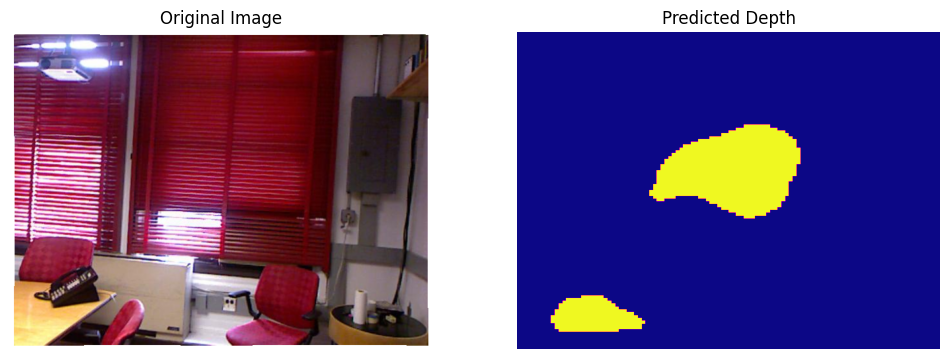

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class DepthEstimationModel(nn.Module):
    def __init__(self):
        super(DepthEstimationModel, self).__init__()
        # Use MobileNetV2 as the encoder
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.encoder = mobilenet.features
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.encoder(x)
        depth = self.decoder(features)
        return depth

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Create model and move to device
model = DepthEstimationModel().to(device)

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_depth(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict depth
    model.eval()
    with torch.no_grad():
        depth = model(input_tensor)

    # Convert depth to numpy array and resize to original image size
    depth = depth.squeeze().cpu().numpy()
    depth = Image.fromarray((depth * 255).astype('uint8')).resize(image.size)

    return image, depth

# Example usage
image_path = "D:/minie/code/nyu_data/data/nyu2_test/00039_colors.png"  # Replace with your test image path
original_image, predicted_depth = predict_depth(image_path)

# Visualize the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(original_image)
ax1.set_title("Original Image")
ax1.axis('off')
ax2.imshow(predicted_depth, cmap='plasma')
ax2.set_title("Predicted Depth")
ax2.axis('off')
plt.show()

# Save the model
torch.save(model.state_dict(), "depth_estimation_mobilenet.pth")
